# FB Prophet Model - Wage Rate ($)

Training (1997-2020), Training (2021-2023)

# Packages & Data Loading

## Packages

In [1]:
# Import packages
import pandas as pd
import numpy as np
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error
import optuna
from io import StringIO
import requests
import matplotlib.pyplot as plt

from prophet.plot import plot_plotly, plot_components_plotly
import plotly.graph_objects as go

## Data Loading

In [2]:
# Load data from Google Drive
file_id = '117pk3NKZPfYmHQyP452HeMV7_8Jq6_W0'

# Create the download URL
download_url = f'https://drive.google.com/uc?export=download&id={file_id}'

# Use requests to get file content
response = requests.get(download_url)
response.raise_for_status()  # Ensure no error occurred

# Load the CSV directly into a DataFrame
csv_data = StringIO(response.text)
df = pd.read_csv(csv_data)

In [3]:
# Prepare and process data
df_selected = df[['ref_date', 'value_wage']].copy()
df_grouped = df_selected.groupby('ref_date').agg(
    median_wage=('value_wage', 'median')
).reset_index()
df_grouped['ref_date'] = pd.to_datetime(df_grouped['ref_date'])
df_grouped.set_index('ref_date', inplace=True)

# FB Prophet Model

## Assign Training & Testing Sets

In [4]:
# Split into training and testing sets
train_data = df_grouped['1997-01-01':'2020-12-01']
test_data = df_grouped['2021-01-01':'2023-12-01']
train_data = train_data.reset_index().rename(columns={'ref_date': 'ds', 'median_wage': 'y'})
test_data = test_data.reset_index().rename(columns={'ref_date': 'ds', 'median_wage': 'y'})


# Cross Validation

In [5]:
# Optuna optimization
def optimize_prophet(trial):
    # Define hyperparameters
    changepoint_prior_scale = trial.suggest_float('changepoint_prior_scale', 0.001, 0.5, log=True)
    seasonality_prior_scale = trial.suggest_float('seasonality_prior_scale', 0.01, 10.0, log=True)
    holidays_prior_scale = trial.suggest_float('holidays_prior_scale', 0.01, 10.0, log=True)
    seasonality_mode = trial.suggest_categorical('seasonality_mode', ['additive', 'multiplicative'])

    # Initialize model with suggested parameters
    model = Prophet(
        changepoint_prior_scale=changepoint_prior_scale,
        seasonality_prior_scale=seasonality_prior_scale,
        holidays_prior_scale=holidays_prior_scale,
        seasonality_mode=seasonality_mode
    )
    model.fit(train_data)

    # Perform cross-validation
    df_cv = cross_validation(model, initial='7300 days', period='365 days', horizon='365 days')
    df_p = performance_metrics(df_cv)
    return df_p['rmse'].mean()

# Model Parameters

In [6]:
# Optimize using Optuna
study = optuna.create_study(direction='minimize')
study.optimize(optimize_prophet, n_trials=50)

# Best parameters
best_params = study.best_params
print("Best Parameters:", best_params)

# Train model with optimized parameters
optimized_model = Prophet(**best_params)
optimized_model.fit(train_data)

[I 2024-11-30 20:02:27,319] A new study created in memory with name: no-name-7eba7b4e-5caf-4fc5-8add-9f870bfd39c2
20:02:27 - cmdstanpy - INFO - Chain [1] start processing
20:02:27 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

20:02:27 - cmdstanpy - INFO - Chain [1] start processing
20:02:28 - cmdstanpy - INFO - Chain [1] done processing
20:02:28 - cmdstanpy - INFO - Chain [1] start processing
20:02:28 - cmdstanpy - INFO - Chain [1] done processing
20:02:28 - cmdstanpy - INFO - Chain [1] start processing
20:02:28 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-30 20:02:28,585] Trial 0 finished with value: 0.5078103495885111 and parameters: {'changepoint_prior_scale': 0.0011340483426072463, 'seasonality_prior_scale': 0.01803913090459845, 'holidays_prior_scale': 0.028268213599509463, 'seasonality_mode': 'multiplicative'}. Best is trial 0 with value: 0.5078103495885111.
20:02:28 - cmdstanpy - INFO - Chain [1] start processing
20:02:28 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

20:02:28 - cmdstanpy - INFO - Chain [1] start processing
20:02:29 - cmdstanpy - INFO - Chain [1] done processing
20:02:29 - cmdstanpy - INFO - Chain [1] start processing
20:02:29 - cmdstanpy - INFO - Chain [1] done processing
20:02:29 - cmdstanpy - INFO - Chain [1] start processing
20:02:29 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-30 20:02:29,556] Trial 1 finished with value: 0.5193601425247699 and parameters: {'changepoint_prior_scale': 0.00286102047305546, 'seasonality_prior_scale': 2.628679784448796, 'holidays_prior_scale': 1.2535009494668743, 'seasonality_mode': 'multiplicative'}. Best is trial 0 with value: 0.5078103495885111.
20:02:29 - cmdstanpy - INFO - Chain [1] start processing
20:02:29 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

20:02:29 - cmdstanpy - INFO - Chain [1] start processing
20:02:29 - cmdstanpy - INFO - Chain [1] done processing
20:02:30 - cmdstanpy - INFO - Chain [1] start processing
20:02:30 - cmdstanpy - INFO - Chain [1] done processing
20:02:30 - cmdstanpy - INFO - Chain [1] start processing
20:02:30 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-30 20:02:30,475] Trial 2 finished with value: 0.46397415446406537 and parameters: {'changepoint_prior_scale': 0.003718542661685089, 'seasonality_prior_scale': 0.12988316654173437, 'holidays_prior_scale': 0.019544537901003058, 'seasonality_mode': 'additive'}. Best is trial 2 with value: 0.46397415446406537.
20:02:30 - cmdstanpy - INFO - Chain [1] start processing
20:02:30 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

20:02:30 - cmdstanpy - INFO - Chain [1] start processing
20:02:31 - cmdstanpy - INFO - Chain [1] done processing
20:02:31 - cmdstanpy - INFO - Chain [1] start processing
20:02:31 - cmdstanpy - INFO - Chain [1] done processing
20:02:31 - cmdstanpy - INFO - Chain [1] start processing
20:02:31 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-30 20:02:31,622] Trial 3 finished with value: 0.47969777680008635 and parameters: {'changepoint_prior_scale': 0.2108858456651104, 'seasonality_prior_scale': 3.3390094116080276, 'holidays_prior_scale': 3.345468597215335, 'seasonality_mode': 'additive'}. Best is trial 2 with value: 0.46397415446406537.
20:02:31 - cmdstanpy - INFO - Chain [1] start processing
20:02:31 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

20:02:31 - cmdstanpy - INFO - Chain [1] start processing
20:02:32 - cmdstanpy - INFO - Chain [1] done processing
20:02:32 - cmdstanpy - INFO - Chain [1] start processing
20:02:32 - cmdstanpy - INFO - Chain [1] done processing
20:02:32 - cmdstanpy - INFO - Chain [1] start processing
20:02:32 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-30 20:02:32,629] Trial 4 finished with value: 0.5346029031207453 and parameters: {'changepoint_prior_scale': 0.0035768156200504577, 'seasonality_prior_scale': 5.904542449174324, 'holidays_prior_scale': 1.8383320200407849, 'seasonality_mode': 'multiplicative'}. Best is trial 2 with value: 0.46397415446406537.
20:02:32 - cmdstanpy - INFO - Chain [1] start processing
20:02:32 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

20:02:32 - cmdstanpy - INFO - Chain [1] start processing
20:02:33 - cmdstanpy - INFO - Chain [1] done processing
20:02:33 - cmdstanpy - INFO - Chain [1] start processing
20:02:33 - cmdstanpy - INFO - Chain [1] done processing
20:02:33 - cmdstanpy - INFO - Chain [1] start processing
20:02:33 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-30 20:02:33,514] Trial 5 finished with value: 0.535071265811255 and parameters: {'changepoint_prior_scale': 0.0035032466719564616, 'seasonality_prior_scale': 0.025941304318625766, 'holidays_prior_scale': 0.10310735573765384, 'seasonality_mode': 'multiplicative'}. Best is trial 2 with value: 0.46397415446406537.
20:02:33 - cmdstanpy - INFO - Chain [1] start processing
20:02:33 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

20:02:33 - cmdstanpy - INFO - Chain [1] start processing
20:02:33 - cmdstanpy - INFO - Chain [1] done processing
20:02:34 - cmdstanpy - INFO - Chain [1] start processing
20:02:34 - cmdstanpy - INFO - Chain [1] done processing
20:02:34 - cmdstanpy - INFO - Chain [1] start processing
20:02:34 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-30 20:02:34,537] Trial 6 finished with value: 0.5448749678239755 and parameters: {'changepoint_prior_scale': 0.02169187362006491, 'seasonality_prior_scale': 0.504080663909975, 'holidays_prior_scale': 0.09054723986050059, 'seasonality_mode': 'multiplicative'}. Best is trial 2 with value: 0.46397415446406537.
20:02:34 - cmdstanpy - INFO - Chain [1] start processing
20:02:34 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

20:02:34 - cmdstanpy - INFO - Chain [1] start processing
20:02:34 - cmdstanpy - INFO - Chain [1] done processing
20:02:35 - cmdstanpy - INFO - Chain [1] start processing
20:02:35 - cmdstanpy - INFO - Chain [1] done processing
20:02:35 - cmdstanpy - INFO - Chain [1] start processing
20:02:35 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-30 20:02:35,406] Trial 7 finished with value: 0.47021793163046616 and parameters: {'changepoint_prior_scale': 0.0036994494482345134, 'seasonality_prior_scale': 0.7667535371497992, 'holidays_prior_scale': 7.4906128110848, 'seasonality_mode': 'additive'}. Best is trial 2 with value: 0.46397415446406537.
20:02:35 - cmdstanpy - INFO - Chain [1] start processing
20:02:35 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

20:02:35 - cmdstanpy - INFO - Chain [1] start processing
20:02:35 - cmdstanpy - INFO - Chain [1] done processing
20:02:36 - cmdstanpy - INFO - Chain [1] start processing
20:02:36 - cmdstanpy - INFO - Chain [1] done processing
20:02:36 - cmdstanpy - INFO - Chain [1] start processing
20:02:36 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-30 20:02:36,466] Trial 8 finished with value: 0.4778388871208724 and parameters: {'changepoint_prior_scale': 0.3091792497840177, 'seasonality_prior_scale': 4.90954976437214, 'holidays_prior_scale': 0.11063986066057066, 'seasonality_mode': 'additive'}. Best is trial 2 with value: 0.46397415446406537.
20:02:36 - cmdstanpy - INFO - Chain [1] start processing
20:02:36 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

20:02:36 - cmdstanpy - INFO - Chain [1] start processing
20:02:37 - cmdstanpy - INFO - Chain [1] done processing
20:02:37 - cmdstanpy - INFO - Chain [1] start processing
20:02:37 - cmdstanpy - INFO - Chain [1] done processing
20:02:37 - cmdstanpy - INFO - Chain [1] start processing
20:02:37 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-30 20:02:37,620] Trial 9 finished with value: 0.5363102672869707 and parameters: {'changepoint_prior_scale': 0.1761372345402004, 'seasonality_prior_scale': 1.7454988076434772, 'holidays_prior_scale': 0.6134248083584853, 'seasonality_mode': 'multiplicative'}. Best is trial 2 with value: 0.46397415446406537.
20:02:37 - cmdstanpy - INFO - Chain [1] start processing
20:02:37 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

20:02:37 - cmdstanpy - INFO - Chain [1] start processing
20:02:38 - cmdstanpy - INFO - Chain [1] done processing
20:02:38 - cmdstanpy - INFO - Chain [1] start processing
20:02:38 - cmdstanpy - INFO - Chain [1] done processing
20:02:38 - cmdstanpy - INFO - Chain [1] start processing
20:02:38 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-30 20:02:38,544] Trial 10 finished with value: 0.4942606932237068 and parameters: {'changepoint_prior_scale': 0.023284030142789614, 'seasonality_prior_scale': 0.10309056429210715, 'holidays_prior_scale': 0.012902636679619037, 'seasonality_mode': 'additive'}. Best is trial 2 with value: 0.46397415446406537.
20:02:38 - cmdstanpy - INFO - Chain [1] start processing
20:02:38 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

20:02:38 - cmdstanpy - INFO - Chain [1] start processing
20:02:38 - cmdstanpy - INFO - Chain [1] done processing
20:02:39 - cmdstanpy - INFO - Chain [1] start processing
20:02:39 - cmdstanpy - INFO - Chain [1] done processing
20:02:39 - cmdstanpy - INFO - Chain [1] start processing
20:02:39 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-30 20:02:39,502] Trial 11 finished with value: 0.5040136258308078 and parameters: {'changepoint_prior_scale': 0.013006691897690244, 'seasonality_prior_scale': 0.2470576302444499, 'holidays_prior_scale': 7.993898801608876, 'seasonality_mode': 'additive'}. Best is trial 2 with value: 0.46397415446406537.
20:02:39 - cmdstanpy - INFO - Chain [1] start processing
20:02:39 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

20:02:39 - cmdstanpy - INFO - Chain [1] start processing
20:02:39 - cmdstanpy - INFO - Chain [1] done processing
20:02:40 - cmdstanpy - INFO - Chain [1] start processing
20:02:40 - cmdstanpy - INFO - Chain [1] done processing
20:02:40 - cmdstanpy - INFO - Chain [1] start processing
20:02:40 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-30 20:02:40,445] Trial 12 finished with value: 0.4925073616168845 and parameters: {'changepoint_prior_scale': 0.007801527986536824, 'seasonality_prior_scale': 0.0798738892686521, 'holidays_prior_scale': 0.3060958667649257, 'seasonality_mode': 'additive'}. Best is trial 2 with value: 0.46397415446406537.
20:02:40 - cmdstanpy - INFO - Chain [1] start processing
20:02:40 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

20:02:40 - cmdstanpy - INFO - Chain [1] start processing
20:02:40 - cmdstanpy - INFO - Chain [1] done processing
20:02:40 - cmdstanpy - INFO - Chain [1] start processing
20:02:41 - cmdstanpy - INFO - Chain [1] done processing
20:02:41 - cmdstanpy - INFO - Chain [1] start processing
20:02:41 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-30 20:02:41,268] Trial 13 finished with value: 0.45655856628573177 and parameters: {'changepoint_prior_scale': 0.0010545751005949895, 'seasonality_prior_scale': 0.7756468579377124, 'holidays_prior_scale': 0.011674523744708468, 'seasonality_mode': 'additive'}. Best is trial 13 with value: 0.45655856628573177.
20:02:41 - cmdstanpy - INFO - Chain [1] start processing
20:02:41 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

20:02:41 - cmdstanpy - INFO - Chain [1] start processing
20:02:41 - cmdstanpy - INFO - Chain [1] done processing
20:02:41 - cmdstanpy - INFO - Chain [1] start processing
20:02:41 - cmdstanpy - INFO - Chain [1] done processing
20:02:41 - cmdstanpy - INFO - Chain [1] start processing
20:02:42 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-30 20:02:42,120] Trial 14 finished with value: 0.45949148990351085 and parameters: {'changepoint_prior_scale': 0.0010554677939807835, 'seasonality_prior_scale': 0.16234466538685066, 'holidays_prior_scale': 0.012142033810700573, 'seasonality_mode': 'additive'}. Best is trial 13 with value: 0.45655856628573177.
20:02:42 - cmdstanpy - INFO - Chain [1] start processing
20:02:42 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

20:02:42 - cmdstanpy - INFO - Chain [1] start processing
20:02:42 - cmdstanpy - INFO - Chain [1] done processing
20:02:42 - cmdstanpy - INFO - Chain [1] start processing
20:02:42 - cmdstanpy - INFO - Chain [1] done processing
20:02:42 - cmdstanpy - INFO - Chain [1] start processing
20:02:42 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-30 20:02:42,940] Trial 15 finished with value: 0.4429626917345491 and parameters: {'changepoint_prior_scale': 0.0015141952309123028, 'seasonality_prior_scale': 0.9144326087594796, 'holidays_prior_scale': 0.04446253079009021, 'seasonality_mode': 'additive'}. Best is trial 15 with value: 0.4429626917345491.
20:02:43 - cmdstanpy - INFO - Chain [1] start processing
20:02:43 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

20:02:43 - cmdstanpy - INFO - Chain [1] start processing
20:02:43 - cmdstanpy - INFO - Chain [1] done processing
20:02:43 - cmdstanpy - INFO - Chain [1] start processing
20:02:43 - cmdstanpy - INFO - Chain [1] done processing
20:02:43 - cmdstanpy - INFO - Chain [1] start processing
20:02:43 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-30 20:02:43,882] Trial 16 finished with value: 0.4844953823404566 and parameters: {'changepoint_prior_scale': 0.051478783669632586, 'seasonality_prior_scale': 1.068941545593226, 'holidays_prior_scale': 0.04148483201677905, 'seasonality_mode': 'additive'}. Best is trial 15 with value: 0.4429626917345491.
20:02:44 - cmdstanpy - INFO - Chain [1] start processing
20:02:44 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

20:02:44 - cmdstanpy - INFO - Chain [1] start processing
20:02:44 - cmdstanpy - INFO - Chain [1] done processing
20:02:44 - cmdstanpy - INFO - Chain [1] start processing
20:02:44 - cmdstanpy - INFO - Chain [1] done processing
20:02:44 - cmdstanpy - INFO - Chain [1] start processing
20:02:44 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-30 20:02:44,796] Trial 17 finished with value: 0.4490865707131421 and parameters: {'changepoint_prior_scale': 0.0013647002890928128, 'seasonality_prior_scale': 0.38474371744188773, 'holidays_prior_scale': 0.05004951211033443, 'seasonality_mode': 'additive'}. Best is trial 15 with value: 0.4429626917345491.
20:02:44 - cmdstanpy - INFO - Chain [1] start processing
20:02:45 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

20:02:45 - cmdstanpy - INFO - Chain [1] start processing
20:02:45 - cmdstanpy - INFO - Chain [1] done processing
20:02:45 - cmdstanpy - INFO - Chain [1] start processing
20:02:45 - cmdstanpy - INFO - Chain [1] done processing
20:02:45 - cmdstanpy - INFO - Chain [1] start processing
20:02:45 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-30 20:02:45,815] Trial 18 finished with value: 0.48209368553525594 and parameters: {'changepoint_prior_scale': 0.07773397974255093, 'seasonality_prior_scale': 0.045342608814876305, 'holidays_prior_scale': 0.05290215061318779, 'seasonality_mode': 'additive'}. Best is trial 15 with value: 0.4429626917345491.
20:02:45 - cmdstanpy - INFO - Chain [1] start processing
20:02:45 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

20:02:46 - cmdstanpy - INFO - Chain [1] start processing
20:02:46 - cmdstanpy - INFO - Chain [1] done processing
20:02:46 - cmdstanpy - INFO - Chain [1] start processing
20:02:46 - cmdstanpy - INFO - Chain [1] done processing
20:02:46 - cmdstanpy - INFO - Chain [1] start processing
20:02:46 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-30 20:02:46,730] Trial 19 finished with value: 0.44306188513917183 and parameters: {'changepoint_prior_scale': 0.0018731077345380104, 'seasonality_prior_scale': 0.3080646897439926, 'holidays_prior_scale': 0.23500957825080768, 'seasonality_mode': 'additive'}. Best is trial 15 with value: 0.4429626917345491.
20:02:46 - cmdstanpy - INFO - Chain [1] start processing
20:02:46 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

20:02:47 - cmdstanpy - INFO - Chain [1] start processing
20:02:47 - cmdstanpy - INFO - Chain [1] done processing
20:02:47 - cmdstanpy - INFO - Chain [1] start processing
20:02:47 - cmdstanpy - INFO - Chain [1] done processing
20:02:47 - cmdstanpy - INFO - Chain [1] start processing
20:02:47 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-30 20:02:47,682] Trial 20 finished with value: 0.4964146707264751 and parameters: {'changepoint_prior_scale': 0.008787974503525801, 'seasonality_prior_scale': 1.4664071525160185, 'holidays_prior_scale': 0.2602273076559846, 'seasonality_mode': 'additive'}. Best is trial 15 with value: 0.4429626917345491.
20:02:47 - cmdstanpy - INFO - Chain [1] start processing
20:02:47 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

20:02:48 - cmdstanpy - INFO - Chain [1] start processing
20:02:48 - cmdstanpy - INFO - Chain [1] done processing
20:02:48 - cmdstanpy - INFO - Chain [1] start processing
20:02:48 - cmdstanpy - INFO - Chain [1] done processing
20:02:48 - cmdstanpy - INFO - Chain [1] start processing
20:02:48 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-30 20:02:48,600] Trial 21 finished with value: 0.45947264038538466 and parameters: {'changepoint_prior_scale': 0.0019460966877409122, 'seasonality_prior_scale': 0.37692240471080596, 'holidays_prior_scale': 0.19268883081857155, 'seasonality_mode': 'additive'}. Best is trial 15 with value: 0.4429626917345491.
20:02:48 - cmdstanpy - INFO - Chain [1] start processing
20:02:48 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

20:02:48 - cmdstanpy - INFO - Chain [1] start processing
20:02:49 - cmdstanpy - INFO - Chain [1] done processing
20:02:49 - cmdstanpy - INFO - Chain [1] start processing
20:02:49 - cmdstanpy - INFO - Chain [1] done processing
20:02:49 - cmdstanpy - INFO - Chain [1] start processing
20:02:49 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-30 20:02:49,533] Trial 22 finished with value: 0.4344028635311416 and parameters: {'changepoint_prior_scale': 0.001970613099842485, 'seasonality_prior_scale': 0.31669983151344994, 'holidays_prior_scale': 0.5407882545092946, 'seasonality_mode': 'additive'}. Best is trial 22 with value: 0.4344028635311416.
20:02:49 - cmdstanpy - INFO - Chain [1] start processing
20:02:49 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

20:02:49 - cmdstanpy - INFO - Chain [1] start processing
20:02:49 - cmdstanpy - INFO - Chain [1] done processing
20:02:50 - cmdstanpy - INFO - Chain [1] start processing
20:02:50 - cmdstanpy - INFO - Chain [1] done processing
20:02:50 - cmdstanpy - INFO - Chain [1] start processing
20:02:50 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-30 20:02:50,454] Trial 23 finished with value: 0.4824397462943806 and parameters: {'changepoint_prior_scale': 0.006450577487759116, 'seasonality_prior_scale': 0.24217386940377608, 'holidays_prior_scale': 0.6094610550119456, 'seasonality_mode': 'additive'}. Best is trial 22 with value: 0.4344028635311416.
20:02:50 - cmdstanpy - INFO - Chain [1] start processing
20:02:50 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

20:02:50 - cmdstanpy - INFO - Chain [1] start processing
20:02:50 - cmdstanpy - INFO - Chain [1] done processing
20:02:51 - cmdstanpy - INFO - Chain [1] start processing
20:02:51 - cmdstanpy - INFO - Chain [1] done processing
20:02:51 - cmdstanpy - INFO - Chain [1] start processing
20:02:51 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-30 20:02:51,396] Trial 24 finished with value: 0.43989847106229285 and parameters: {'changepoint_prior_scale': 0.002027300400006263, 'seasonality_prior_scale': 0.6274681248264784, 'holidays_prior_scale': 0.5485603130682627, 'seasonality_mode': 'additive'}. Best is trial 22 with value: 0.4344028635311416.
20:02:51 - cmdstanpy - INFO - Chain [1] start processing
20:02:51 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

20:02:51 - cmdstanpy - INFO - Chain [1] start processing
20:02:51 - cmdstanpy - INFO - Chain [1] done processing
20:02:51 - cmdstanpy - INFO - Chain [1] start processing
20:02:51 - cmdstanpy - INFO - Chain [1] done processing
20:02:52 - cmdstanpy - INFO - Chain [1] start processing
20:02:52 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-30 20:02:52,289] Trial 25 finished with value: 0.4354346768240136 and parameters: {'changepoint_prior_scale': 0.0020311091605329378, 'seasonality_prior_scale': 8.956605892482989, 'holidays_prior_scale': 0.533055461008244, 'seasonality_mode': 'additive'}. Best is trial 22 with value: 0.4344028635311416.
20:02:52 - cmdstanpy - INFO - Chain [1] start processing
20:02:52 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

20:02:52 - cmdstanpy - INFO - Chain [1] start processing
20:02:52 - cmdstanpy - INFO - Chain [1] done processing
20:02:52 - cmdstanpy - INFO - Chain [1] start processing
20:02:52 - cmdstanpy - INFO - Chain [1] done processing
20:02:53 - cmdstanpy - INFO - Chain [1] start processing
20:02:53 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-30 20:02:53,244] Trial 26 finished with value: 0.4902707034055562 and parameters: {'changepoint_prior_scale': 0.005743421198695661, 'seasonality_prior_scale': 9.77045145560828, 'holidays_prior_scale': 0.6059064679565972, 'seasonality_mode': 'additive'}. Best is trial 22 with value: 0.4344028635311416.
20:02:53 - cmdstanpy - INFO - Chain [1] start processing
20:02:53 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

20:02:53 - cmdstanpy - INFO - Chain [1] start processing
20:02:53 - cmdstanpy - INFO - Chain [1] done processing
20:02:53 - cmdstanpy - INFO - Chain [1] start processing
20:02:53 - cmdstanpy - INFO - Chain [1] done processing
20:02:54 - cmdstanpy - INFO - Chain [1] start processing
20:02:54 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-30 20:02:54,148] Trial 27 finished with value: 0.4555885918746986 and parameters: {'changepoint_prior_scale': 0.0021070991189747045, 'seasonality_prior_scale': 0.01022711122604612, 'holidays_prior_scale': 1.1178831701929477, 'seasonality_mode': 'additive'}. Best is trial 22 with value: 0.4344028635311416.
20:02:54 - cmdstanpy - INFO - Chain [1] start processing
20:02:54 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

20:02:54 - cmdstanpy - INFO - Chain [1] start processing
20:02:54 - cmdstanpy - INFO - Chain [1] done processing
20:02:54 - cmdstanpy - INFO - Chain [1] start processing
20:02:54 - cmdstanpy - INFO - Chain [1] done processing
20:02:54 - cmdstanpy - INFO - Chain [1] start processing
20:02:55 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-30 20:02:55,086] Trial 28 finished with value: 0.5002652532403478 and parameters: {'changepoint_prior_scale': 0.019124567030081443, 'seasonality_prior_scale': 0.048084850771754735, 'holidays_prior_scale': 0.4549479421308781, 'seasonality_mode': 'additive'}. Best is trial 22 with value: 0.4344028635311416.
20:02:55 - cmdstanpy - INFO - Chain [1] start processing
20:02:55 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

20:02:55 - cmdstanpy - INFO - Chain [1] start processing
20:02:55 - cmdstanpy - INFO - Chain [1] done processing
20:02:55 - cmdstanpy - INFO - Chain [1] start processing
20:02:55 - cmdstanpy - INFO - Chain [1] done processing
20:02:55 - cmdstanpy - INFO - Chain [1] start processing
20:02:55 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-30 20:02:55,973] Trial 29 finished with value: 0.5332683042755143 and parameters: {'changepoint_prior_scale': 0.002446702297016519, 'seasonality_prior_scale': 2.22091045195949, 'holidays_prior_scale': 3.3466164059065844, 'seasonality_mode': 'multiplicative'}. Best is trial 22 with value: 0.4344028635311416.
20:02:56 - cmdstanpy - INFO - Chain [1] start processing
20:02:56 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

20:02:56 - cmdstanpy - INFO - Chain [1] start processing
20:02:56 - cmdstanpy - INFO - Chain [1] done processing
20:02:56 - cmdstanpy - INFO - Chain [1] start processing
20:02:56 - cmdstanpy - INFO - Chain [1] done processing
20:02:56 - cmdstanpy - INFO - Chain [1] start processing
20:02:56 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-30 20:02:56,924] Trial 30 finished with value: 0.5007828111922847 and parameters: {'changepoint_prior_scale': 0.005214199101544511, 'seasonality_prior_scale': 9.408700059042074, 'holidays_prior_scale': 1.0158119210784093, 'seasonality_mode': 'additive'}. Best is trial 22 with value: 0.4344028635311416.
20:02:57 - cmdstanpy - INFO - Chain [1] start processing
20:02:57 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

20:02:57 - cmdstanpy - INFO - Chain [1] start processing
20:02:57 - cmdstanpy - INFO - Chain [1] done processing
20:02:57 - cmdstanpy - INFO - Chain [1] start processing
20:02:57 - cmdstanpy - INFO - Chain [1] done processing
20:02:57 - cmdstanpy - INFO - Chain [1] start processing
20:02:57 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-30 20:02:57,860] Trial 31 finished with value: 0.4410879218476491 and parameters: {'changepoint_prior_scale': 0.0015340541734627006, 'seasonality_prior_scale': 0.9602458031704049, 'holidays_prior_scale': 0.3958048438368705, 'seasonality_mode': 'additive'}. Best is trial 22 with value: 0.4344028635311416.
20:02:57 - cmdstanpy - INFO - Chain [1] start processing
20:02:58 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

20:02:58 - cmdstanpy - INFO - Chain [1] start processing
20:02:58 - cmdstanpy - INFO - Chain [1] done processing
20:02:58 - cmdstanpy - INFO - Chain [1] start processing
20:02:58 - cmdstanpy - INFO - Chain [1] done processing
20:02:58 - cmdstanpy - INFO - Chain [1] start processing
20:02:58 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-30 20:02:58,790] Trial 32 finished with value: 0.438632933142499 and parameters: {'changepoint_prior_scale': 0.001560392849722591, 'seasonality_prior_scale': 0.5839457539237884, 'holidays_prior_scale': 0.40421380273728985, 'seasonality_mode': 'additive'}. Best is trial 22 with value: 0.4344028635311416.
20:02:58 - cmdstanpy - INFO - Chain [1] start processing
20:02:58 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

20:02:59 - cmdstanpy - INFO - Chain [1] start processing
20:02:59 - cmdstanpy - INFO - Chain [1] done processing
20:02:59 - cmdstanpy - INFO - Chain [1] start processing
20:02:59 - cmdstanpy - INFO - Chain [1] done processing
20:02:59 - cmdstanpy - INFO - Chain [1] start processing
20:02:59 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-30 20:02:59,671] Trial 33 finished with value: 0.4609151365697939 and parameters: {'changepoint_prior_scale': 0.002395487594856566, 'seasonality_prior_scale': 0.4678101327945809, 'holidays_prior_scale': 0.15452797957884554, 'seasonality_mode': 'additive'}. Best is trial 22 with value: 0.4344028635311416.
20:02:59 - cmdstanpy - INFO - Chain [1] start processing
20:02:59 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

20:03:00 - cmdstanpy - INFO - Chain [1] start processing
20:03:00 - cmdstanpy - INFO - Chain [1] done processing
20:03:00 - cmdstanpy - INFO - Chain [1] start processing
20:03:00 - cmdstanpy - INFO - Chain [1] done processing
20:03:00 - cmdstanpy - INFO - Chain [1] start processing
20:03:00 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-30 20:03:00,661] Trial 34 finished with value: 0.452844998939376 and parameters: {'changepoint_prior_scale': 0.004376945778332297, 'seasonality_prior_scale': 0.20438608651122353, 'holidays_prior_scale': 0.8595130247971916, 'seasonality_mode': 'additive'}. Best is trial 22 with value: 0.4344028635311416.
20:03:00 - cmdstanpy - INFO - Chain [1] start processing
20:03:00 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

20:03:00 - cmdstanpy - INFO - Chain [1] start processing
20:03:01 - cmdstanpy - INFO - Chain [1] done processing
20:03:01 - cmdstanpy - INFO - Chain [1] start processing
20:03:01 - cmdstanpy - INFO - Chain [1] done processing
20:03:01 - cmdstanpy - INFO - Chain [1] start processing
20:03:01 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-30 20:03:01,575] Trial 35 finished with value: 0.5161498149709375 and parameters: {'changepoint_prior_scale': 0.002910580457502849, 'seasonality_prior_scale': 0.5966489773036457, 'holidays_prior_scale': 1.7797457088247925, 'seasonality_mode': 'multiplicative'}. Best is trial 22 with value: 0.4344028635311416.
20:03:01 - cmdstanpy - INFO - Chain [1] start processing
20:03:01 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

20:03:01 - cmdstanpy - INFO - Chain [1] start processing
20:03:01 - cmdstanpy - INFO - Chain [1] done processing
20:03:02 - cmdstanpy - INFO - Chain [1] start processing
20:03:02 - cmdstanpy - INFO - Chain [1] done processing
20:03:02 - cmdstanpy - INFO - Chain [1] start processing
20:03:02 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-30 20:03:02,498] Trial 36 finished with value: 0.4995185027667112 and parameters: {'changepoint_prior_scale': 0.010390661583711174, 'seasonality_prior_scale': 3.4653798566847143, 'holidays_prior_scale': 2.034400911029256, 'seasonality_mode': 'additive'}. Best is trial 22 with value: 0.4344028635311416.
20:03:02 - cmdstanpy - INFO - Chain [1] start processing
20:03:02 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

20:03:02 - cmdstanpy - INFO - Chain [1] start processing
20:03:02 - cmdstanpy - INFO - Chain [1] done processing
20:03:03 - cmdstanpy - INFO - Chain [1] start processing
20:03:03 - cmdstanpy - INFO - Chain [1] done processing
20:03:03 - cmdstanpy - INFO - Chain [1] start processing
20:03:03 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-30 20:03:03,448] Trial 37 finished with value: 0.5177725066099635 and parameters: {'changepoint_prior_scale': 0.00289181219178993, 'seasonality_prior_scale': 0.13732574335437958, 'holidays_prior_scale': 0.41458406768301437, 'seasonality_mode': 'multiplicative'}. Best is trial 22 with value: 0.4344028635311416.
20:03:03 - cmdstanpy - INFO - Chain [1] start processing
20:03:03 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

20:03:03 - cmdstanpy - INFO - Chain [1] start processing
20:03:03 - cmdstanpy - INFO - Chain [1] done processing
20:03:03 - cmdstanpy - INFO - Chain [1] start processing
20:03:04 - cmdstanpy - INFO - Chain [1] done processing
20:03:04 - cmdstanpy - INFO - Chain [1] start processing
20:03:04 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-30 20:03:04,330] Trial 38 finished with value: 0.45294041373065 and parameters: {'changepoint_prior_scale': 0.0015930578949620764, 'seasonality_prior_scale': 0.06849804741803948, 'holidays_prior_scale': 0.7881039245992224, 'seasonality_mode': 'additive'}. Best is trial 22 with value: 0.4344028635311416.
20:03:04 - cmdstanpy - INFO - Chain [1] start processing
20:03:04 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

20:03:04 - cmdstanpy - INFO - Chain [1] start processing
20:03:04 - cmdstanpy - INFO - Chain [1] done processing
20:03:04 - cmdstanpy - INFO - Chain [1] start processing
20:03:04 - cmdstanpy - INFO - Chain [1] done processing
20:03:05 - cmdstanpy - INFO - Chain [1] start processing
20:03:05 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-30 20:03:05,290] Trial 39 finished with value: 0.45832804609926275 and parameters: {'changepoint_prior_scale': 0.004343338763241815, 'seasonality_prior_scale': 1.2586111361711478, 'holidays_prior_scale': 2.902905496881675, 'seasonality_mode': 'additive'}. Best is trial 22 with value: 0.4344028635311416.
20:03:05 - cmdstanpy - INFO - Chain [1] start processing
20:03:05 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

20:03:05 - cmdstanpy - INFO - Chain [1] start processing
20:03:05 - cmdstanpy - INFO - Chain [1] done processing
20:03:05 - cmdstanpy - INFO - Chain [1] start processing
20:03:05 - cmdstanpy - INFO - Chain [1] done processing
20:03:06 - cmdstanpy - INFO - Chain [1] start processing
20:03:06 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-30 20:03:06,250] Trial 40 finished with value: 0.5074856637132745 and parameters: {'changepoint_prior_scale': 0.0011341393654173033, 'seasonality_prior_scale': 2.958694339848863, 'holidays_prior_scale': 0.14661478104393488, 'seasonality_mode': 'multiplicative'}. Best is trial 22 with value: 0.4344028635311416.
20:03:06 - cmdstanpy - INFO - Chain [1] start processing
20:03:06 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

20:03:06 - cmdstanpy - INFO - Chain [1] start processing
20:03:06 - cmdstanpy - INFO - Chain [1] done processing
20:03:06 - cmdstanpy - INFO - Chain [1] start processing
20:03:06 - cmdstanpy - INFO - Chain [1] done processing
20:03:07 - cmdstanpy - INFO - Chain [1] start processing
20:03:07 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-30 20:03:07,134] Trial 41 finished with value: 0.455290174613614 and parameters: {'changepoint_prior_scale': 0.001444389162696222, 'seasonality_prior_scale': 0.49544790350141965, 'holidays_prior_scale': 0.44663362390159417, 'seasonality_mode': 'additive'}. Best is trial 22 with value: 0.4344028635311416.
20:03:07 - cmdstanpy - INFO - Chain [1] start processing
20:03:07 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

20:03:07 - cmdstanpy - INFO - Chain [1] start processing
20:03:07 - cmdstanpy - INFO - Chain [1] done processing
20:03:07 - cmdstanpy - INFO - Chain [1] start processing
20:03:07 - cmdstanpy - INFO - Chain [1] done processing
20:03:07 - cmdstanpy - INFO - Chain [1] start processing
20:03:08 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-30 20:03:08,081] Trial 42 finished with value: 0.46867453783859914 and parameters: {'changepoint_prior_scale': 0.003349815879429191, 'seasonality_prior_scale': 5.217047749719853, 'holidays_prior_scale': 0.39283753441974173, 'seasonality_mode': 'additive'}. Best is trial 22 with value: 0.4344028635311416.
20:03:08 - cmdstanpy - INFO - Chain [1] start processing
20:03:08 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

20:03:08 - cmdstanpy - INFO - Chain [1] start processing
20:03:08 - cmdstanpy - INFO - Chain [1] done processing
20:03:08 - cmdstanpy - INFO - Chain [1] start processing
20:03:08 - cmdstanpy - INFO - Chain [1] done processing
20:03:08 - cmdstanpy - INFO - Chain [1] start processing
20:03:08 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-30 20:03:08,994] Trial 43 finished with value: 0.4448574090851189 and parameters: {'changepoint_prior_scale': 0.002013488077322071, 'seasonality_prior_scale': 0.6795661853561509, 'holidays_prior_scale': 1.3298838478579624, 'seasonality_mode': 'additive'}. Best is trial 22 with value: 0.4344028635311416.
20:03:09 - cmdstanpy - INFO - Chain [1] start processing
20:03:09 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

20:03:09 - cmdstanpy - INFO - Chain [1] start processing
20:03:09 - cmdstanpy - INFO - Chain [1] done processing
20:03:09 - cmdstanpy - INFO - Chain [1] start processing
20:03:09 - cmdstanpy - INFO - Chain [1] done processing
20:03:09 - cmdstanpy - INFO - Chain [1] start processing
20:03:09 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-30 20:03:09,966] Trial 44 finished with value: 0.461199293582725 and parameters: {'changepoint_prior_scale': 0.0010052259756448442, 'seasonality_prior_scale': 1.0782544250440127, 'holidays_prior_scale': 0.624317646852339, 'seasonality_mode': 'additive'}. Best is trial 22 with value: 0.4344028635311416.
20:03:10 - cmdstanpy - INFO - Chain [1] start processing
20:03:10 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

20:03:10 - cmdstanpy - INFO - Chain [1] start processing
20:03:10 - cmdstanpy - INFO - Chain [1] done processing
20:03:10 - cmdstanpy - INFO - Chain [1] start processing
20:03:10 - cmdstanpy - INFO - Chain [1] done processing
20:03:10 - cmdstanpy - INFO - Chain [1] start processing
20:03:10 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-30 20:03:10,920] Trial 45 finished with value: 0.44208539863008184 and parameters: {'changepoint_prior_scale': 0.0027593324967244526, 'seasonality_prior_scale': 1.8704908915811282, 'holidays_prior_scale': 0.3540826702545585, 'seasonality_mode': 'additive'}. Best is trial 22 with value: 0.4344028635311416.
20:03:11 - cmdstanpy - INFO - Chain [1] start processing
20:03:11 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

20:03:11 - cmdstanpy - INFO - Chain [1] start processing
20:03:11 - cmdstanpy - INFO - Chain [1] done processing
20:03:11 - cmdstanpy - INFO - Chain [1] start processing
20:03:11 - cmdstanpy - INFO - Chain [1] done processing
20:03:11 - cmdstanpy - INFO - Chain [1] start processing
20:03:11 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-30 20:03:11,841] Trial 46 finished with value: 0.44812043075763436 and parameters: {'changepoint_prior_scale': 0.0014434940123356776, 'seasonality_prior_scale': 0.3220818454558512, 'holidays_prior_scale': 0.18499655066802878, 'seasonality_mode': 'additive'}. Best is trial 22 with value: 0.4344028635311416.
20:03:11 - cmdstanpy - INFO - Chain [1] start processing
20:03:12 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

20:03:12 - cmdstanpy - INFO - Chain [1] start processing
20:03:12 - cmdstanpy - INFO - Chain [1] done processing
20:03:12 - cmdstanpy - INFO - Chain [1] start processing
20:03:12 - cmdstanpy - INFO - Chain [1] done processing
20:03:12 - cmdstanpy - INFO - Chain [1] start processing
20:03:12 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-30 20:03:12,918] Trial 47 finished with value: 0.49001327790336385 and parameters: {'changepoint_prior_scale': 0.03420421135327777, 'seasonality_prior_scale': 4.118773660997048, 'holidays_prior_scale': 0.08111583885238563, 'seasonality_mode': 'additive'}. Best is trial 22 with value: 0.4344028635311416.
20:03:13 - cmdstanpy - INFO - Chain [1] start processing
20:03:13 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

20:03:13 - cmdstanpy - INFO - Chain [1] start processing
20:03:13 - cmdstanpy - INFO - Chain [1] done processing
20:03:13 - cmdstanpy - INFO - Chain [1] start processing
20:03:13 - cmdstanpy - INFO - Chain [1] done processing
20:03:13 - cmdstanpy - INFO - Chain [1] start processing
20:03:13 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-30 20:03:13,801] Trial 48 finished with value: 0.5279032574809956 and parameters: {'changepoint_prior_scale': 0.004364602178631183, 'seasonality_prior_scale': 0.7996226010589635, 'holidays_prior_scale': 0.2763356254390146, 'seasonality_mode': 'multiplicative'}. Best is trial 22 with value: 0.4344028635311416.
20:03:13 - cmdstanpy - INFO - Chain [1] start processing
20:03:14 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

20:03:14 - cmdstanpy - INFO - Chain [1] start processing
20:03:14 - cmdstanpy - INFO - Chain [1] done processing
20:03:14 - cmdstanpy - INFO - Chain [1] start processing
20:03:14 - cmdstanpy - INFO - Chain [1] done processing
20:03:14 - cmdstanpy - INFO - Chain [1] start processing
20:03:14 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-30 20:03:14,727] Trial 49 finished with value: 0.5077745888987935 and parameters: {'changepoint_prior_scale': 0.014434299194398925, 'seasonality_prior_scale': 0.19841789924843523, 'holidays_prior_scale': 1.3822861560239161, 'seasonality_mode': 'additive'}. Best is trial 22 with value: 0.4344028635311416.
20:03:14 - cmdstanpy - INFO - Chain [1] start processing
20:03:14 - cmdstanpy - INFO - Chain [1] done processing


Best Parameters: {'changepoint_prior_scale': 0.001970613099842485, 'seasonality_prior_scale': 0.31669983151344994, 'holidays_prior_scale': 0.5407882545092946, 'seasonality_mode': 'additive'}


# Model Predictions

In [13]:
# Generate the future dataframe and forecast
future = optimized_model.make_future_dataframe(periods=36, freq='ME')  # Add 36 months to the end of training data
forecast = optimized_model.predict(future)

## Evaluate on test data
test_data['ds'] = test_data['ds'].dt.to_period('M').dt.to_timestamp('M')

# Convert to plain datetime for comparison
forecast_dates = pd.to_datetime(forecast['ds'])
test_dates = pd.to_datetime(test_data['ds'])

# Find common dates manually using set operations
common_dates = list(set(forecast_dates) & set(test_dates))  # Use intersection of sets

# Align forecast and test data on common dates
evaluation = test_data.set_index('ds').loc[common_dates]
evaluation = evaluation.join(forecast.set_index('ds')[['yhat']], how='inner')
evaluation = evaluation.dropna(subset=['y', 'yhat'])

# Model evaluation metrics
actuals = evaluation['y'].values
predictions = evaluation['yhat'].values
mse = mean_squared_error(actuals, predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(actuals, predictions)
mape = np.mean(np.abs((actuals - predictions) / actuals)) * 100

# Print final model evaluation statistics
print(f"Final Model Evaluation:")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Absolute Percentage Error (MAPE): {mape}")

Final Model Evaluation:
Mean Squared Error (MSE): 0.5528016778709852
Root Mean Squared Error (RMSE): 0.7435063401686534
Mean Absolute Error (MAE): 0.5522523146586706
Mean Absolute Percentage Error (MAPE): 2.134382402567395


# Visualizations

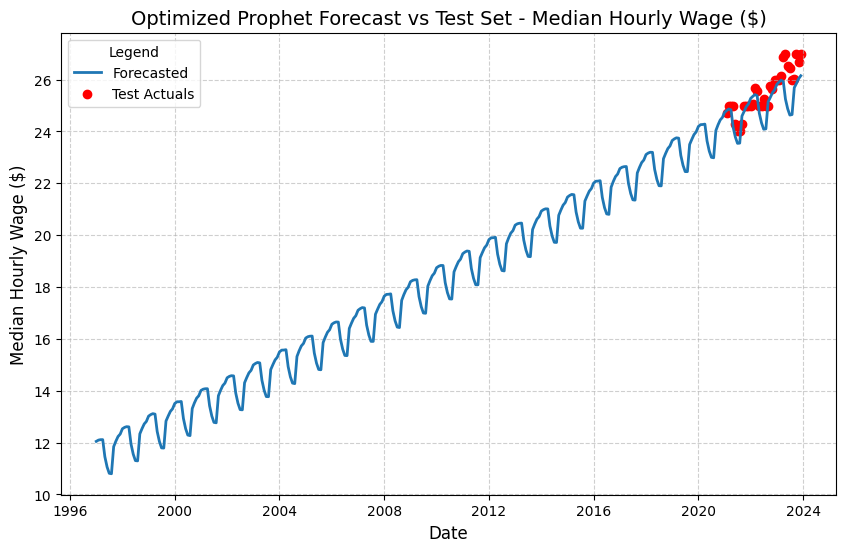

In [8]:
# Plot results
plt.figure(figsize=(10, 6))
plt.plot(forecast['ds'], forecast['yhat'], label='Forecasted', linestyle='-', linewidth=2)
plt.scatter(evaluation.index, evaluation['y'], label='Test Actuals', color='red', marker='o')
plt.title("Optimized Prophet Forecast vs Test Set - Median Hourly Wage ($)", fontsize=14)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Median Hourly Wage ($)", fontsize=12)
plt.legend(title="Legend", fontsize=10)
plt.grid(visible=True, linestyle='--', alpha=0.6)
plt.show()

In [12]:
# Generate plot
fig = plot_plotly(optimized_model, forecast)

# Add labels and title
fig.update_layout(
    title="Prophet Forecast - Median Hourly Wage ($)",                 
    xaxis_title="Date",                       
    yaxis_title="Median Hourly Wage ($)",        
    legend_title="Legend",                   
    font=dict(size=12),                       
)

# Show plot
fig.show()

In [10]:
# Generate plot
fig = plot_plotly(optimized_model, forecast)

# Add test data 
fig.add_trace(
    go.Scatter(
        x=test_data['ds'],  # x-axis (test data dates)
        y=test_data['y'],  # y-axis (actual values)
        mode='markers+lines',
        name='True Values (Test Data)',
        line=dict(color='red', dash='dot'),  
        marker=dict(color='red')
    )
)

# Adjust x-axis range (2021-2023)
fig.update_layout(
    xaxis=dict(
        range=['2021-01-01', '2023-12-31'],  # Set x-axis range
        title='Date',  # Add x-axis title
    ),
    yaxis=dict(
        title='Median Hourly Wage ($)',  # Add y-axis title
    ),
    title='Prophet Forecast with Test Data (2021-2023) - Median Hourly Wage ($)',  # Add plot title
)

# Show plot
fig.show()

In [11]:
# Generate plot
fig = plot_components_plotly(optimized_model, forecast)

# Add title and labels
fig.update_layout(
    title="Prophet Forecast - Median Hourly Wage ($)",     
    font=dict(size=12),                      
)       

# Show plot
fig.show()